In [1]:
from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from thllib import util
import figurefirst as fifi
from scipy import signal

In [2]:
sp = 20. #sample period ms
MK_TON1 = 10/1000. #ms
MK_TON2 = 10/1000. #ms
MK_TOFF1 = 100/1000. #ms
MK_TOFF2 = 300/1000.

def make_single_kernel(times,tauon1,tauoff1):
    kx = np.copy(times)
    kon1 = lambda x:np.exp(((-1*tauon1)/(x)))
    koff1 = lambda x:np.exp((-1*x)/tauoff1)
    k1 = (kon1(kx)*koff1(kx))
    return k1/np.max(k1)

In [3]:
%matplotlib inline

In [4]:
fly = flb.NetFly(1530,rootpath='/media/imager/FlyDataD/FlyDB/')
fly.open_signals()

In [5]:
popt = [0.01636028, 0.23604393]

In [6]:
flynumbers = \
list(range(1389,1402)) #+ \

In [7]:
flylist = [flb.NetFly(fnum) for fnum in flynumbers]

In [8]:
fly = flylist[4]

In [9]:
fly.open_signals()

In [10]:
snum = 4
l = fly.block_data['left', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
r = fly.block_data['right', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
x = fly.block_data['common', 'x_pos', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]

idxs = fly.block_data['common','idx', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
times = np.arange(len(x))*0.02
sig = fly.ca_cam_left_model_fits['i1'][idxs]

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide


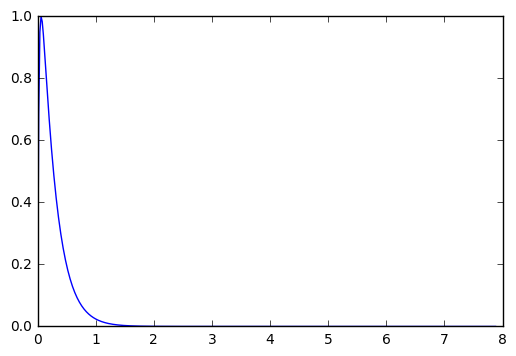

In [11]:
plt.plot(times,make_single_kernel(times,*popt))

In [100]:
test_freq = np.array(fly.wb_freq[idxs[0]:idxs[-1]])
test_ca_sig = np.array(fly.ca_cam_left_model_fits['iii3'][idxs[0]:idxs[-1]])
test_ca_time = np.array(fly.time[idxs[0]:idxs[-1]])
test_ca_time -= test_ca_time[0]

In [119]:
resample_rate = 1000. #Hz
resample_times = np.arange(test_ca_time[-1]*resample_rate)*(1/resample_rate)

In [102]:
resampled_ca,resampled_t = signal.resample(test_ca_sig,
                                           len(resample_times),
                                           test_ca_time,window = 'hamming')

resampled_freq,resampled_t = signal.resample(test_freq,
                                           len(resample_times),
                                           test_ca_time,window = 'hamming')

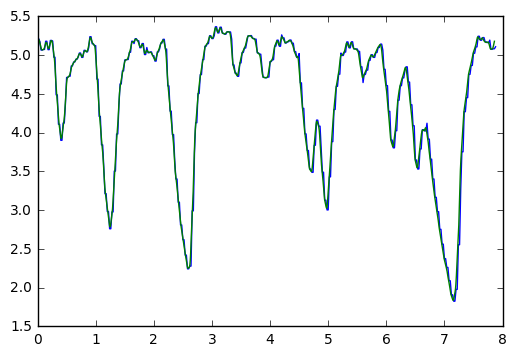

In [103]:
plt.plot(times,fly.ca_cam_left_model_fits['iii3'][idxs])
plt.plot(resample_times,resampled_ca)
#plt.plot(wiener_deconvolution(fly.ca_cam_left_model_fits['i1'][idxs]*10,kernel,1.5))
#plt.plot(wiener_deconvolution(fly.ca_cam_left_model_fits['i1'][idxs]*10,kernel*0.1,1.5))

In [104]:
#flight_epoch_idx = np.squeeze(np.argwhere(np.squeeze(resampled_freq)>50))
impulse_idxs = list()
#spike_idx = flight_epoch_idx[0]
spike_idx = 1
spike_time = resample_times[spike_idx]
#while(spike_idx < flight_epoch_idx[-1]):
while(spike_time<resample_times[-1]):
    spike_idx = np.argwhere(resample_times<spike_time)[-1][0]
    #print spike_idx
    impulse_idxs.append(spike_idx)
    isi = 1./resampled_freq[spike_idx]
    spike_time += isi

In [124]:
impulse_idxs = np.array(impulse_idxs)

In [105]:
resampled_ca -= np.min(resampled_ca)

In [159]:
kernel_gain = 0.05

In [179]:
kernel = make_single_kernel(resample_times,*popt)

def forward_optimize(resampled_ca,resample_times,
                     kernel,
                     objective_window_s = 2,kernel_gain = 0.05):
    kernel = kernel*kernel_gain
    recon = np.zeros_like(resample_times)
    impulses = np.zeros_like(resample_times)
    objective_window_idx = objective_window_s*resample_rate
    max_idx = len(resample_times)
    end_first_loop = max_idx - objective_window_idx
    last_imp = np.argwhere(impulse_idxs < end_first_loop)[-1][0]
    for imp_idx,nxt_idx in zip(impulse_idxs[:last_imp],impulse_idxs[1:last_imp+1]):
        if (imp_idx + objective_window_idx) > max_idx:
            objective_window = max_idx - imp_idx
        imp_window = impulses[imp_idx:imp_idx+2000]
        n1 = np.linalg.norm(recon[imp_idx:nxt_idx]-resampled_ca[imp_idx:nxt_idx])
        recon[imp_idx:imp_idx+2000] += kernel[:2000]
        n2 = np.linalg.norm(recon[imp_idx:nxt_idx] - resampled_ca[imp_idx:nxt_idx])
        if n2>n1:
            recon[imp_idx:imp_idx+2000] -= kernel[:2000]
        else:
            impulses[imp_idx] = 1
    return recon,impulses

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide


In [183]:
errors = list()
for kg in np.linspace(0,2,100):
    recon,impulses = forward_optimize(resampled_ca,resample_times,kernel,kernel_gain = kg)
    errors.append(np.linalg.norm(resampled_ca[1000:5000]-recon[1000:5000]))

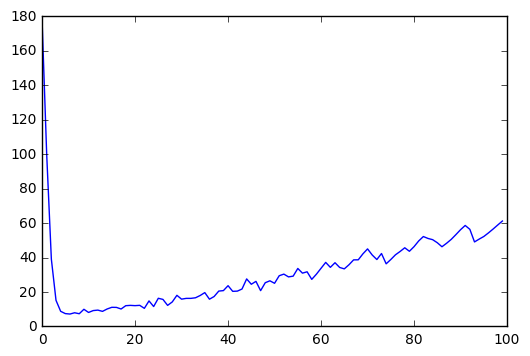

In [184]:
plt.plot(errors)

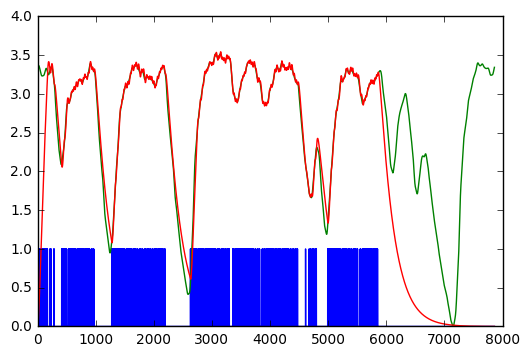

In [181]:
plt.plot(impulses)
plt.plot(resampled_ca)
plt.plot(recon)
#plt.gca().set_xbound(4000,6000)